In [1]:
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
import tests.amc.amc_parser as amc_parser
import motiflets.motiflets as mtfls
from motiflets.plotting import *
import motiflets_uni.motiflets as mtfls_uni
from motiflets_uni.plotting import Motiflets as Motiflets_uni
from sklearn.decomposition import PCA

/home/niyaz/Programme/miniconda3/envs/ubuntu-motiflets-mv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
k_max = 16
motif_length = 100
n_dims_rest = 25
n_dims_rest2 = 17

def get_joint_pos_dict(c_joints, c_motion):
    c_joints['root'].set_motion(c_motion)
    out_dict = {}
    for k1, v1 in c_joints['root'].to_dict().items():
        for k2, v2 in zip('xyz', v1.coordinate[:, 0]):
            out_dict['{}_{}'.format(k1, k2)] = v2
    return out_dict


def exclude_body_joints(df):
    # Filter body joints as suggested by Yeh
    exclude = ['root', 'lowerback', 'upperback',
               'thorax', 'lowerneck', 'upperneck', 'head']
    exclude_bones = []
    exclude_bones.extend([x + "_" + k for x in exclude for k in 'xyz'])
    exclude_bones

    return df[~df.index.isin(exclude_bones)]


def include_joints(df, include, add_xyz=True):
    include_bones = []

    if add_xyz:
        include_bones.extend([x + "_" + k for x in include for k in 'xyz'])
    else:
        include_bones = include

    return df[df.index.isin(include_bones)]

amc_name = "13_17" #"Boxing Motions"
asf_path = "datasets/motion_data/13.asf"
amc_path = 'datasets/motion_data/' + amc_name + '.amc'

joints_to_use = ['rclavicle', 'rhumerus', 'rradius', 'rwrist',
             'rhand', 'rfingers', 'rthumb',
             'rfemur', 'rtibia', 'rfoot', 'rtoes']
add_xyz=True

joints = amc_parser.parse_asf(asf_path)
motions = amc_parser.parse_amc(amc_path)

df = pd.DataFrame([get_joint_pos_dict(joints, c_motion) for c_motion in motions]).T
df = exclude_body_joints(df)
df = include_joints(df, joints_to_use, add_xyz=add_xyz)

print("Used joints:", joints_to_use)
series = df.values
print(f'DatensatzLänge: {series.shape[1]}')
print(series.shape)


Used joints: ['rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb', 'rfemur', 'rtibia', 'rfoot', 'rtoes']
DatensatzLänge: 4840
(33, 4840)


In [3]:
def norm_extent(df_full, dists, dims, elbows):
    dists_norm = []
    for elbow in range(len(dists)):
        if dims[elbow] is None:
            dists_norm.append(None)
            continue
        variance = 1
        for i, column in enumerate(df_full.T):
            if i in dims[elbow]:
                variance = variance + np.var(df_full.T[column].to_numpy())

        dists_norm.append(dists[elbow] / np.sqrt(variance / len(dims)))

    return dists_norm

In [4]:
ml_full = Motiflets(amc_name, df,
                dimension_labels=df.index
                )

dists_full, motiflets_full, motiflets_dims_full, elbow_points_full = ml_full.fit_k_elbow(
    k_max,
    plot_elbows=False,
    plot_motifs_as_grid=False,
    motif_length=motif_length)

dists_full_norm = norm_extent(df, dists_full, motiflets_dims_full, elbow_points_full)

Data (33, 4840)


Chosen window-size: 100 in 11.2 s
Elbow Points [13]


In [5]:
ml_rest = Motiflets(amc_name, df,
                dimension_labels=df.index,
                n_dims=n_dims_rest
                )

dists_rest, motiflets_rest, motiflets_dims_rest, elbow_points_rest = ml_rest.fit_k_elbow(
    k_max,
    plot_elbows=False,
    plot_motifs_as_grid=False,
    motif_length=motif_length)

dists_rest_norm = norm_extent(df, dists_rest, motiflets_dims_rest, elbow_points_rest)

Data (33, 4840)


Chosen window-size: 100 in 8.5 s
Elbow Points [14]


In [6]:
ml_rest2 = Motiflets(amc_name, df,
                dimension_labels=df.index,
                n_dims=n_dims_rest2
                )

dists_rest2, motiflets_rest2, motiflets_dims_rest2, elbow_points_rest2 = ml_rest2.fit_k_elbow(
                k_max,
                plot_elbows=False,
                plot_motifs_as_grid=False,
                motif_length=motif_length)

dists_rest2_norm = norm_extent(df, dists_rest2, motiflets_dims_rest2, elbow_points_rest2)

Data (33, 4840)


Chosen window-size: 100 in 7.3 s
Elbow Points [9]


In [7]:
dists_rest2[-1]
motiflets_rest2[-1]

array([2126, 3390, 3598, 2517,  139, 4372, 1138,  522, 3266, 2305,  280,
        968, 1653, 1966, 4552, 3853], dtype=int32)

In [8]:
pca = PCA(n_components=1)
np_pca = pca.fit_transform(df.T)
series_pca = pd.Series(np_pca.flatten(), index=df.T.index, name='Boxing PCA')

ml_uni = Motiflets_uni(amc_name, series_pca)
dists_uni, motiflets_uni, elbow_points_uni =  ml_uni.fit_k_elbow(
    k_max,
    plot_elbows=False,
    plot_motifs_as_grid=False,
    motif_length=motif_length)

Data 4840


Chosen window-size: 100 in 0.3 s
Elbow Points [11]


In [9]:
np_data = df.T.to_numpy()
mean_centered_data = np_data - np.mean(np_data, axis=0)

cov_matrix = np.cov(mean_centered_data, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

first_eigenvalue = eigenvalues[0]

dists_uni_norm = []
for u_dist in dists_uni:
     dists_uni_norm.append(u_dist / np.sqrt(first_eigenvalue))

print(dists_uni_norm)

[0.00638630055455362, 0.00638630055455362, 0.00638630055455362, 0.023311809590198695, 0.03517251969244893, 0.04014473276508472, 0.06970055302795411, 0.09317870366833635, 0.09967876630075281, 0.12125017885814827, 0.19299870000409844, 0.20586608229705883, 0.24121831389379803, 0.304644026412067, 0.4139945968192674, 0.4868166485705352]


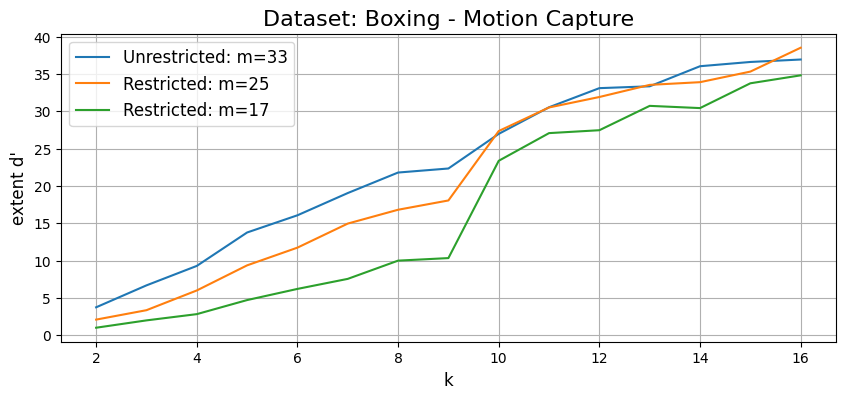

In [10]:
plt.figure(figsize=(10,4))

x_values = [x+2 for x in range(len(dists_full_norm[2:]))]

plt.plot(x_values, dists_full_norm[2:], label=f'Unrestricted: m={df.shape[0]}')
plt.plot(x_values, dists_rest_norm[2:], label=f'Restricted: m={n_dims_rest}')
plt.plot(x_values, dists_rest2_norm[2:], label=f'Restricted: m={n_dims_rest2}')
#plt.plot(x_values, dists_uni_norm[2:], label='PCA')

plt.title("Dataset: Boxing - Motion Capture", fontsize=16)
plt.xlabel('k', fontsize=12)
plt.ylabel('extent d\'', fontsize=12)

plt.legend(fontsize=12)
plt.grid()

plt.savefig("../../Latex/BachelorarbeitFinal/Images/quant/boxing.pdf", bbox_inches='tight', dpi=600)

plt.show()